### RCNN
- CNN으로부터 얻은 feature map을 RNN의 입력으로 사용
- 이 파일에서는 RNN대신 GRU 사용
- CNN으로 나온 feature를 RNN에 input으로 사용할 수 있도록 시계열 형태로 변환해야함 -> 가로 방향의 픽셀 개수만큼의 길이를 갖는 시계열 데이터
- CTC 손실    
    -     하나의 정답을 표현하는 방법이 여러가지 존재할 때 모든 경우의 수에 대한 확률을 더하는 함수임
- 단점
      1.세로 픽셀 개수가 1개이므로 정보의 손실이 발생할 수 있음
      2. 이미지 크키가 커지면 앞의 정보가 흐려져 특징을 추출하기 어려움
- 데이터 전처리
    - 글자 인식을 위해서 글자의 첫 시작에 "\<pad>" 추가

- 모델
    - CRNN
        - input -> basicblock*4 -> cnn -> transpose -> GRU -> MLP -> logsoftmax -> output
    - CNN : ResNet
        - RNN의 입력으로 들어가야 하므로 세로 방향의 픽셀이 1개만 존재해야함
        - converlusion network를 거칠 때마다 세로 방향의 픽셀 수 줄이기
        - input -> cnn 3*5 -> batch normalization -> ReLU -> cnn 3*3 -> batch normalization -> ReLU -> output + input downsampling

In [121]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fournierp/captcha-version-2-images")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/fournierp/captcha-version-2-images/versions/2


In [122]:
import os
len(os.listdir(path+'/samples'))

1071

### 데이터
- path 안에 samples 라는 폴더있음
- samples안에 png 형식의 이미지 1071개 있음

In [123]:
import string
import matplotlib.pyplot as plt
import glob
import tqdm
from PIL import Image
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adam import Adam

832.0


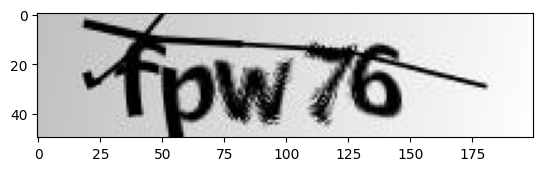

In [169]:
imgfiles=glob.glob(os.path.join(path,'samples/*.png'))
img=Image.open(imgfiles[0])
print(len(imgfiles)*0.8)
plt.imshow(img)
plt.show()

In [125]:
def get_BOW(corpus):
  BOW={"<pad>":0}

  for letter in corpus:
    if letter not in BOW:
      BOW[letter]=len(BOW.keys())

  return BOW

In [191]:
class Captcha(Dataset):
  def __init__(self,pth,train=True):
    self.corpus=string.ascii_lowercase+string.digits #소문자와 숫자만 정답
    self.BOW=get_BOW(self.corpus)

    self.imgs=glob.glob(pth+"/*.png")

    self.train=train
    self.trainset=self.imgs[:int(len(self.imgs)*0.8)]
    self.testset=self.imgs[int(len(self.imgs)*0.8):]

  def get_seq(self,line):
    # 캡챠의 문자를 고유 번호로 치환
    label=[]

    for letter in line:
      label.append(self.BOW[letter]) #BOW에 letter를 대입하여 고유 값 get
      print(self.BOW[letter])
    return label

  def __len__(self):
    if self.train:
      return len(self.trainset)
    else:
      return len(self.testset)

  def __getitem__(self,idx):
    if self.train:
      #이미지
      data=Image.open(self.trainset[idx]).convert('RGB')

      #이미지 파일이름이 label임
      label=self.trainset[idx].split('/')[-1]
      label=label.split('.png')[0]
      label=self.get_seq(label) #글자를 숫자형식의 고유값으로 변환

      data=np.array(data).astype(np.float32)
      data=np.transpose(data,(2,0,1)) #pytorch는 채널이 맨 앞에 와야 함
      label=np.array(label)
      return data,label

    else:
      data=Image.open(self.testset[idx]).convert('RGB')
      label=self.testset[idx].split('/')[-1]
      label=label.split('.png')[0]
      label=self.get_seq(label)

      data=np.array(data).astype(np.float32)
      label=np.array(label)

      return data,label



In [171]:
class BasicBlock(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=(3,5),stride=(2,1)):
    super(BasicBlock,self).__init__()

    self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride)
    self.conv2=nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=(3,3),padding=1)
    self.downsampling=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride)
    self.bn1=nn.BatchNorm2d(num_features=out_channels)
    self.bn2=nn.BatchNorm2d(num_features=out_channels)

    self.relu=nn.ReLU()

  def forward(self,x):
    x_=x
    x=self.conv1(x)
    x=self.bn1(x)
    x=self.relu(x)
    x=self.conv2(x)
    x=self.bn2(x)

    x_=self.downsampling(x_)
    x+=x_
    x=self.relu(x)

    return x

In [180]:
class CRNN(nn.Module):
  def __init__(self,output_size):
    super(CRNN,self).__init__()

    self.c1=BasicBlock(in_channels=3,out_channels=64)
    self.c2=BasicBlock(in_channels=64,out_channels=64)
    self.c3=BasicBlock(in_channels=64,out_channels=64)
    self.c4=BasicBlock(in_channels=64,out_channels=64)
    self.c5=nn.Conv2d(64,64,kernel_size=(2,5))

    self.gru=nn.GRU(64,64,batch_first=False)

    self.fc1=nn.Linear(in_features=64,out_features=128)
    self.fc2=nn.Linear(in_features=128,out_features=output_size)
    self.relu=nn.ReLU()

  def forward(self,x):
    x=self.c1(x) # [batch_size, channel, height, width]
    x=self.c2(x)
    x=self.c3(x)
    x=self.c4(x)
    x=self.c5(x)

    x=x.view(x.shape[0],64,-1) # [batch_size, channel, width]
    x=x.permute(2,0,1) # [width, batch_size, channel]
    x,_=self.gru(x)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)  #[width, batch_size, channel(num_class)]
    x=F.log_softmax(x,dim=-1) #dim=-1 : 마지막 dimenstion의 softmax값 계산, num_class의 값 계산

    return x


In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
dataset=Captcha(pth=os.path.join(path,'samples'))
loader=DataLoader(dataset,batch_size=8)

model=CRNN(output_size=len(dataset.BOW)).to(device)
optim=Adam(model.parameters(),lr=0.0001)

for epoch in range(100):
  iterator=tqdm.tqdm(loader)
  for data,label in iterator:

    optim.zero_grad()
    preds=model(data.to(device))

    preds_size=torch.IntTensor([preds.size(0)]*8).to(device)
    target_len=torch.IntTensor([len(txt) for txt in label]).to(device)
    loss=nn.CTCLoss(blank=0)(preds,label.to(device),preds_size,target_len)

    loss.backward()
    optim.step()

    iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")
  torch.save(model.state_dict(),'CRNN.pth')

<ipython-input-196-162e489d8ae5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('CRNN.pth',map_location=device))


5
34
33
14
31
c1: torch.Size([1, 64, 24, 196])
c2: torch.Size([1, 64, 11, 192])
c3: torch.Size([1, 64, 5, 188])
c4: torch.Size([1, 64, 2, 184])
c5: torch.Size([1, 64, 1, 180])
view: torch.Size([1, 64, 180])
permute: torch.Size([180, 1, 64])
gur: torch.Size([180, 1, 64])
fc1: torch.Size([180, 1, 128])
relu: torch.Size([180, 1, 128])
fc2: torch.Size([180, 1, 37])
log_softmax: torch.Size([180, 1, 37])


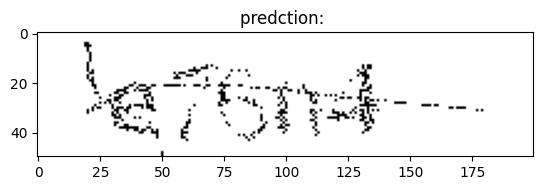

In [196]:
model.load_state_dict(torch.load('CRNN.pth',map_location=device))

with torch.no_grad():
  testset=Captcha(pth=os.path.join(path,'samples'),train=False)
  test_img,label=testset[0] #test_img = [H,W,C]

  input_tensor=torch.unsqueeze(torch.tensor(test_img),dim=0) #test_img = [1,H,W,C]
  input_tensor=input_tensor.permute(0,3,1,2).to(device) #test_img = [1,C,H,W]

  pred=torch.argmax(model(input_tensor),dim=-1) #dim=-1 차원의 최대값 인덱스 반환
  prev_letter=pred[0].item()
  pred_word=""
  for letter in pred:
    if letter.item() !=0 and letter.item() != prev_letter:
      pred_word += list(testset.BOW.keys())[letter.items()]
    prev_letter=letter.item()

  plt.imshow(test_img)
  plt.title('predction: ' + pred_word)
  plt.show()